# TDA Tutorial: Point Clouds
By: David Cole and Victor M. Zavala

Based on work done by Dr. Alexander Smith and published [here](https://pubs.acs.org/doi/full/10.1021/acsnano.4c04969). Code for creating the visualizations was constructured with the help of ChatGPT

To access this notebook in Google Colab, please click below:

<a href="https://githubtocolab.com/zavalab/Tutorials/blob/master/CBE660/TDA_Point_Clouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Introduction to Simplicial Complexes

In tutorial 2 and the application above, we introduced cubical complexes, where the complex is created from rectangular faces that can represent a surface. For datasets with nicely spaced data (like images or matrices), this representation works very well. However, not all data will be so nicely structured. An alternative topological object is the simplicial complex. A simplicial complex is a collection of nodes (vertices), edges, and faces (and higher-dimensional counterparts, which we do not consider here). For simplicial complexes, faces are made up of triangles formed by three vertices, where each vertex is connected to the other two vertices.

As with cubical complexes, we can use Gudhi to create the simplicial complex objects. We will use the alpha complex option in Ghudi to construct the object. For a point cloud, we can treat the points as vertices and add edges between vertices based on the distance between vertices. You can think of this as we are expanding a ball with radius $r$ around each point, and when two balls from two different points overlap, we draw an edge between these points. This is visualized in the image below, which comes from the paper of Smith and co-workers ([Topological Data Analysis: Concepts, Computation, and Applications in Chemical Engineering](https://doi.org/10.1016/j.compchemeng.2020.107202), _Computers & Chemical Engineering_ 146:107202).

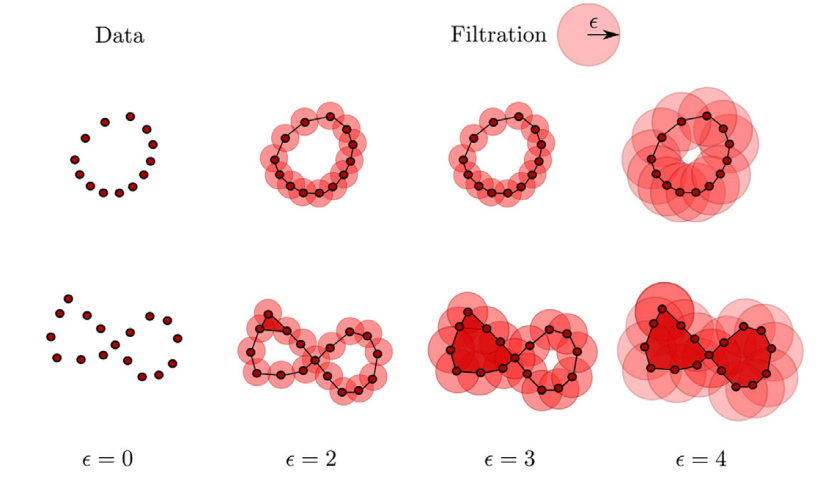

In the case of point clouds, the process of filtration refers to the radius of the balls, $r$ (or $\epsilon$ in the figure above). The alpha complex of Gudhi draws these lines and creates the required structure based on the distances of the points and their filtration value (it also includes some additional computations in determining when lines are drawn using Delauney Traingulation, but that is outside the discussion of this work, and the above explanations will suffice).

Below, we give an example of 2-D point cloud that we will visualize with different filtration levels.

In [ ]:
# If gudhi is not installed, uncomment the line below
#!pip install gudhi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.6 MB/s eta 0:00:00


In [ ]:
# Clone the repo from git to get access to the data
!git clone https://github.com/zavalab/Tutorials.git

In [ ]:
# Load in basic packages
import os
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt

# Navigate to cloned directory
os.chdir("Tutorials/CBE660")

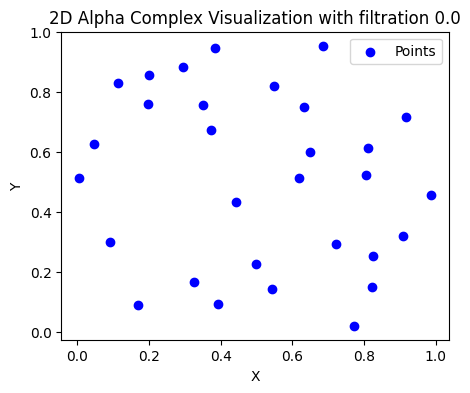

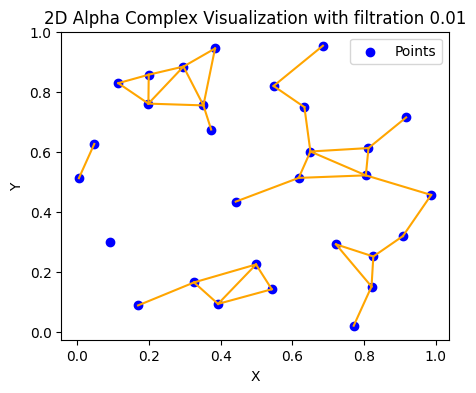

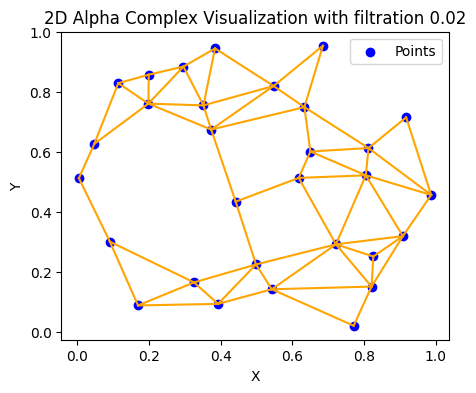

In [ ]:
# Generate a random 2D point cloud and create an alpha complex
np.random.seed(10)
point_cloud = np.random.random((30, 2))  # 2D point cloud
alpha_complex = gd.AlphaComplex(points=point_cloud)
simplex_tree = alpha_complex.create_simplex_tree()

# Get the set of all simplices that are formed below a given filtration value
# The get_filtration() function returns a vector of tuples; The first index of the
# tuple is a vector of points that form the simplex (with length 1, 2, or 3), and
# the second index is the filtration value at which the object appears.
def get_simplices(simplex_tree, filtration_value):
    simplices = [
        simplex[0] for simplex in simplex_tree.get_filtration()
        if simplex[1] <= filtration_value
    ]
    return simplices

# Define a function for plotting the simplices
def plot_simplex(point_cloud, simplices, filtration_value = '0'):
    # Define points and edges
    points = point_cloud
    edges = [(simplex[0], simplex[1]) for simplex in simplices if len(simplex) == 2]

    # Create a scatter plot for points
    plt.figure(figsize=(5,4))
    plt.scatter(points[:, 0], points[:, 1], c='blue', label='Points')

    # Add edges
    for edge in edges:
        plt.plot(
            [points[edge[0]][0], points[edge[1]][0]],
            [points[edge[0]][1], points[edge[1]][1]],
            'orange'
        )

    # Customize the plot
    plt.title(f"2D Alpha Complex Visualization with filtration {filtration_value}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

# Choose a filtration value for visualization
filtration_value1 = 0.0
filtration_value2 = 0.01
filtration_value3 = 0.02


simplices1 = get_simplices(simplex_tree, filtration_value1)
simplices2 = get_simplices(simplex_tree, filtration_value2)
simplices3 = get_simplices(simplex_tree, filtration_value3)

plot_simplex(point_cloud, simplices1, 0.0)
plot_simplex(point_cloud, simplices2, 0.01)
plot_simplex(point_cloud, simplices3, 0.02)



Certain datasets will include datapoints whose spatial positions are important and could give insight into the problem. As a simple example, we will show how the EC curve of two different proteins, constructed from the alpha complex filtrations, results in distinct EC curves. We will load in data for each protein, where the data consists of X, Y, and Z coordinates of atoms contained in a protein (data was originally retrieved from the ProDy Python package).

In [ ]:
# If you are running this code outside of GoogleCollab, you can uncomment the line below to create interactive visuals
#%matplotlib notebook

In [ ]:
protein1 = np.loadtxt("./Data/protein_1aa7.csv", delimiter=',')
protein2 = np.loadtxt("./Data/protein_3l9j.csv", delimiter=',')

We will plot these point clouds of each protein next to each other

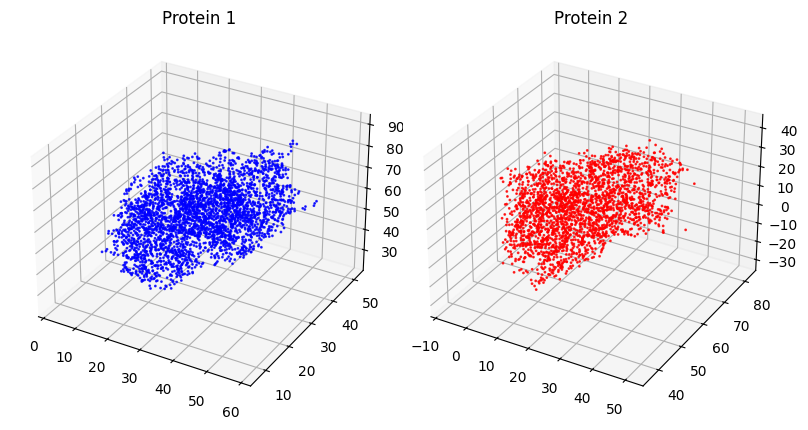

In [ ]:
fig = plt.figure(figsize=(8, 6))


# Plot the first point cloud
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(protein1[:, 0], protein1[:, 1], protein1[:, 2], c='blue',s = 1, alpha=0.8)
ax1.set_title("Protein 1")

# Plot the second point cloud
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(protein2[:, 0], protein2[:, 1], protein2[:, 2],s = 1, c='red', alpha=0.8)
ax2.set_title("Protein 2")

# Show the plot
plt.tight_layout()
plt.show()


On initial inspection, these point clouds are not very informative, and it is difficult to identify characteristics about the points. Using TDA can potentially characterize or capture topological information about this point cloud though.

To help show how the simplicial complexes are formed, we will also visualize one filtration example below for protein 1. Here, we set the filtraiton value to be equal to 0.5, and we can see that some edges start to be formed throughout the graph.

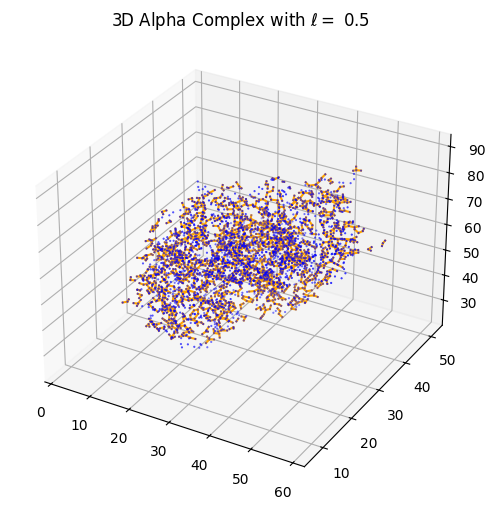

In [ ]:
# Generate a 3D point cloud and create an alpha complex
point_cloud_3d = protein1
alpha_complex_3d = gd.AlphaComplex(points=point_cloud_3d)
simplex_tree_3d = alpha_complex_3d.create_simplex_tree()

# Filter simplices for a specific alpha value
filtration_value_3d = 0.5
simplices_3d = [
    simplex[0] for simplex in simplex_tree_3d.get_filtration()
    if simplex[1] <= filtration_value_3d
]

# Separate points and edges
points_3d = point_cloud_3d
edges_3d = [(simplex[0], simplex[1]) for simplex in simplices_3d if len(simplex) == 2]

# Create a 3D plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s = 0.3, c='blue')

# Add edges
for edge in edges_3d:
    ax.plot(
        [points_3d[edge[0]][0], points_3d[edge[1]][0]],
        [points_3d[edge[0]][1], points_3d[edge[1]][1]],
        [points_3d[edge[0]][2], points_3d[edge[1]][2]],
        color='orange'
    )

# Customize the plot
ax.set_title("3D Alpha Complex with $\ell = $ 0.5")
plt.show()


We will now build the EC curve for each of the two proteins and look at whether it results in any distinct shapes

In [ ]:
# Set up the filtration distance, i.e. the min/max diameter of the balls.
filtration_increment = 5e-3;
numIndices = int(1/filtration_increment) + 1;
filtrations = np.linspace(1,10,numIndices)

def get_EC(data):

    # Construct Alpha Complex (This is the filtration of the 3-dimensional points - constructs the resulting simplicial complex from data)
    alpha_complex = gd.AlphaComplex(data)
    simplex_tree = alpha_complex.create_simplex_tree()
    diag = simplex_tree.persistence()

    # Define a vector for the Euler characteristic
    EC = np.zeros(numIndices);

    # Code to convert filtereted complex into a betti curve and EC curve
    for i in range(numIndices):
        filtration_value = filtrations[i];
        betti_numbers=simplex_tree.persistent_betti_numbers(filtration_value,filtration_value);
        EC[i] = betti_numbers[0] - betti_numbers[1] + betti_numbers[2]

    return EC

EC_p1 = get_EC(protein1)
EC_p2 = get_EC(protein2)

Having computed the EC, we will now visualize the curves. We see distinct shapes in the EC curves and have a quantifiable way to consider the shape of the point cloud.

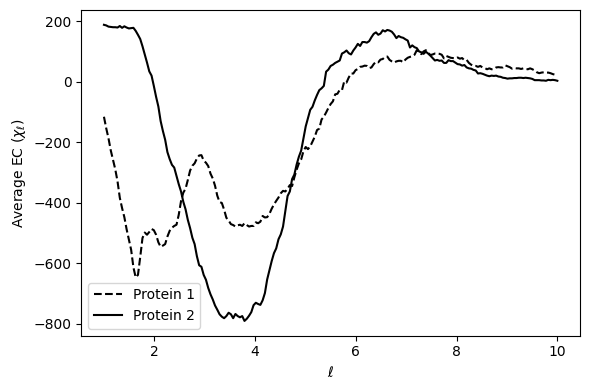

In [ ]:
plt.figure(figsize = (6,4))
plt.plot(filtrations,EC_p1, '--k', label = "Protein 1")
plt.plot(filtrations,EC_p2, 'k', label = "Protein 2")

plt.legend()

plt.xlabel("$\ell$")
plt.ylabel("Average EC ($\chi_{\ell}$)")


plt.tight_layout()
plt.show()